In [19]:
from math import exp 
import numpy as np
from itertools import product
from copy import deepcopy

In [95]:
class Cell:
    def __init__(self,car_num = 0, av_num = 0, length = 0.2 , q_max = 1600, f_speed = 40, dt = 10, jam_density = 240, av_lane = 0,scale_down = 1):
        """
        f_speed: km/h; length: km; jam_density: veh/km; q_max = veh/h
        """
        self.car_num = car_num; self.av_num = av_num
        if self.car_num == 0: # 有的cell没有车辆，避免math error
            self.av_ratio = 0
        else:
            self.av_ratio = self.av_num/self.car_num

        self.length = length; self.f_speed = f_speed; self.q_max = q_max*(1+0.5*self.av_ratio)
        self.dt = dt; self.jam_density = jam_density*(1+0.5*self.av_ratio)
        self.wave_speed = self.q_max/(self.jam_density-self.q_max/self.f_speed)
        self.av_lane = av_lane; self.q_max = q_max*(1+0.5*self.av_ratio)
        self.demand = 0; self.supply = 0; self.density = self.car_num/self.length
        self.scale_down = scale_down; self.left_flow = 0
        self.right_flow = 0; self.down_flow = 0
        self.left_prob = 0; self.right_prob = 0
        self.down_prob = 0; self.left_in = 0
        self.right_in = 0; self.up_in = 0
        self.exp_right_flow = 0 # 拟向右换道车辆数
        self.exp_left_flow = 0 # 拟向左换道车辆数
        self.exp_down_flow = 0 # 拟向下游的车辆数
        self.lc_ratio = 0
        self.q_max_default = 1600

    def update_variable(self, left_num, right_num, down_num, right_av_lane, left_av_lane, down_av_lane): # 这个函数的目的就是根据周围元胞数量来确定车流概率
        """
        :param left_num: 左侧元胞车辆数
        :param right_num: 右侧元胞车辆数
        :param down_num: 下游元胞车辆数
        :return: 
        """
        beta1 = 0.4; beta2 = -5; beta3 = 0.1; beta4 = -1
        self.density = self.car_num/self.length
        self.supply = max(0, min(self.q_max,self.f_speed*self.density))*self.dt/3600 # 这个改动较大
        self.demand = max(0, min(self.q_max,self.wave_speed*(self.jam_density-self.density)))*self.dt/3600
        self.demand = self.demand * (1-self.lc_ratio*0.2) # 举例子
        print(self.car_num,self.supply,self.demand,self.q_max)

    
        left_utility = beta1*(self.car_num-left_num)+beta2 # 隔壁车道车越少，换道之后的效用越高
        right_utility = beta1*(self.car_num-right_num) + beta2  
        down_utility = beta3*(self.car_num-down_num)  + beta4 - 0.4*max(0,16-down_num)
        
        print(right_utility,right_num,left_utility,left_num,down_utility,down_num)
        self.left_prob = exp(left_utility)/(exp(left_utility)+exp(right_utility)+exp(down_utility))
        self.right_prob = exp(right_utility)/(exp(left_utility)+exp(right_utility)+exp(down_utility))
        self.down_prob =  exp(down_utility)/(exp(left_utility)+exp(right_utility)+exp(down_utility))
        # print(self.down_prob)
        self.exp_down_flow = self.down_prob*self.supply
        self.exp_right_flow = self.right_prob*self.supply # 本车道拟向右换道车辆数
        self.exp_left_flow = self.left_prob*self.supply # 本车道拟向右换道车辆数
        
        if self.av_lane:
            self.exp_right_flow = self.car_num - self.av_num
            self.exp_down_flow = min(self.av_num,self.supply)
        if right_av_lane: # 此处假设只有一个车道是自动驾驶车道，当然也可以假设很多，按照比例分配即可，但是现实可能不太好操作
            self.exp_right_flow = self.av_num
        if left_av_lane:
            self.exp_left_flow = self.av_num  
        
        if down_av_lane: # 如果下游是自动驾驶车道，只有自动驾驶车才能往下走,剩下的车按比例换道
            self.exp_down_flow = self.av_num
            self.exp_right_flow = self.right_prob*(self.supply-self.av_num)
            self.exp_left_flow = self.left_prob*(self.supply-self.av_num)


    def update_car_num(self,up_out,down_demand,left_up_in,left_lane_demand,right_up_in,right_lane_demand,right_lane_exp_left_flow,left_lane_exp_right_flow,right_two_lane_exp_left_flow,left_two_lane_exp_right_flow,up_av_ratio, left_av_ratio, right_av_ratio):
        """
        Args:
            right_av_ratio: 
            up_out: 上游元胞想要出来的车辆数
            down_demand: 下游元胞的需求
            left_lane_up_out: 左侧上游想要直行的车辆数
            left_lane_demand: 左侧元胞供给
            right_lane_up_out: 右侧上游想要直行的车辆数
            right_lane_demand: 右侧元胞供给
            right_lane_exp_left_flow: 右侧想要变道的车辆数
            left_lane_exp_right_flow: 左侧想要变道的车辆数
            right_two_lane_exp_left_flow: 右侧第二个车道往右侧车道换道的车辆数
            left_two_lane_exp_right_flow: 左侧第二个车道往左侧车道换道的车辆数
            up_av_ratio: 
            left_av_ratio: 

        Returns:
        """
        #-----------自动驾驶车道有所不同的点：
        if self.av_lane:
            down_demand  = min(down_demand,self.av_num)
            

        # 三个cell进来的车辆数 上游cell 左侧车道的cell 右侧车道的cell
        self.up_in = min(self.demand,up_out) # 当前车道上游元胞向下走的车辆数
        if right_lane_exp_left_flow+left_lane_exp_right_flow>0:          
            self.right_in = min(right_lane_exp_left_flow/(right_lane_exp_left_flow+left_lane_exp_right_flow)*(self.demand-self.up_in), right_lane_exp_left_flow)
            self.left_in = min(left_lane_exp_right_flow/(right_lane_exp_left_flow+left_lane_exp_right_flow)*(self.demand-self.up_in), left_lane_exp_right_flow)
        else:
            self.right_in = 0; self.left_in = 0
       # 需要根据有多少车换道、直行到当前cell来确定换道对supply的影响；目的：体现出换道多交通的负效用
        if self.right_in+self.left_in+self.up_in>0:
            self.lc_ratio = (self.right_in+ self.left_in)/(self.right_in+self.left_in+self.up_in)
        else:
            self.lc_ratio = 0
        
      # --------------------------------------------------------------------
        
        

        # 本cell朝三个方向出去的实际车辆数
        self.down_flow = min(down_demand,self.exp_down_flow) # 向下的流量
        if self.exp_right_flow+right_two_lane_exp_left_flow >0:
            self.right_flow = min(self.exp_right_flow/(self.exp_right_flow+right_two_lane_exp_left_flow)*(right_lane_demand-right_up_in) , self.exp_right_flow)
        else:
            self.right_flow = 0
        
        if self.exp_left_flow+left_two_lane_exp_right_flow > 0:
            self.left_flow = min(self.exp_left_flow/(self.exp_left_flow+left_two_lane_exp_right_flow)*(left_lane_demand-left_up_in) , self.exp_left_flow)
        else:
            self.left_flow = 0

            
    
    # 更新该元胞内部车辆数
        self.car_num = self.car_num + self.up_in + self.right_in + self.left_in - self.right_flow - self.down_flow - self.left_flow
        
        if not self.av_lane:
            self.av_num = (self.car_num-self.right_flow-self.down_flow-self.right_flow)*self.av_ratio + self.up_in*up_av_ratio + self.right_in*right_av_ratio + self.left_in*left_av_ratio 
        else:
            self.av_num = (self.car_num-self.down_flow)*self.av_ratio + self.up_in*up_av_ratio + self.right_in

        if self.car_num == 0:
            self.av_ratio = 0
        else:
            self.av_ratio = self.av_num/self.car_num
            
        
        self.wave_speed = self.q_max/(self.jam_density-self.q_max/self.f_speed)
        self.q_max = self.q_max_default*(1+0.5*self.av_ratio)
        # print(self.car_num)

class source:
    def __init__(self,car_num,av_num , q_max=1600,f_speed = 40,length = 0.2,dt = 10):
            self.car_num = car_num
            self.length = length
            self.q_max = q_max
            self.f_speed = f_speed
            self.density = self.car_num/self.length
            self.dt = dt
            self.supply = max(0, min(self.q_max,self.f_speed*self.density))*self.dt/3600
            self.exp_down_flow = self.supply # source只往下走，不换道，因此，期望能往下的流量就是他的供给
            self.down_flow = self.supply # 实际的流量初始化是不知道的，是和下游相关的，需要update_variable
            self.av_num = av_num
            self.av_ratio = self.av_num/self.car_num
        
        
    def update_variable(self,input_flow, av_input,down_demand):
            self.down_flow = min(self.supply, down_demand)
            self.car_num = self.car_num + input_flow - self.down_flow
            self.av_num = self.av_num + av_input - self.down_flow*self.av_ratio
            self.av_ratio = self.av_num/self.car_num
            self.density = self.car_num/self.length
            self.supply = max(0, min(self.q_max,self.f_speed*self.density))*self.dt/3600
           
        

class sink:
    def __init__(self,av_num):
        self.car_num = 0
        self.demand = 100000000000
        self.av_ratio = 0
        self.av_lane = 0
        self.av_num = av_num



In [96]:
class Agent():
    def __init__(self,lane_num, cell_num, ini_num, ini_av, ini_action, sim_time_step,sys_time,input,av_input): # 注意初始化的av_num
        """
        :param lane_num: 研究的范围内多少条道路
        :param cell_num: 研究范围内没条道路多少个cell
        :param initial_num: 每一个cell一开始多少车辆数，比如我们仿真8:00-8:30，或者仿真8:30-9:00这个值不一样
        :param initial_action: 这个是说的哪些segement是av dedicated lane
        :param simulation_time: 仿真多少个时间步
        :param input: 输入流量
        """
        self.lane_num = lane_num
        self.cell_num = cell_num
        self.ini_num = ini_num
        self.ini_action = ini_action
        self.sim_time_step = sim_time_step
        self.state1 = 0 # 这些状态自己定义哈
        self.state2 = 0
        self.state3 = 0
        self.reward = 0 # reward自己定义
        self.done = False # 是否结束
        self.sys_time = sys_time
        self.num_record = np.zeros([self.lane_num, self.cell_num,self.sim_time_step])
        self.av_ratio_record  = np.zeros([self.lane_num, self.cell_num,self.sim_time_step])
        self.av_num_record = np.zeros([self.lane_num, self.cell_num,self.sim_time_step])
        self.input = input # input 应该是lane num * time step的东西
        self.av_input = av_input

    def run(self):
        # 初始化网络----------------------------------------------------------------
        Road = [[[] for j in range(self.cell_num)] for i in range(self.lane_num)]
        for i,j in product(range(self.lane_num),range(self.cell_num-2)):
            Road[i][j+1] = Cell(car_num = ini_num[i][j+1],av_lane=self.ini_action[i][j+1],av_num= ini_av[i][j+1])
      
        for i in range(self.lane_num):
            Road[i][0] = source(car_num=ini_num[i][0],av_num=ini_av[i][0])
            Road[i][-1] = sink(av_num = ini_av[i][-1])
        # -------------------------------------------------------------------------

        for t in range(self.sim_time_step):
            Road_copy = deepcopy(Road) # 在更新过程中有一些先后顺序，需要破坏Road的性质，因此先拷贝一份,因为要改变Road部分元素，所以要用deepcopy
            
            for i,j in product(range(self.lane_num),range(self.cell_num)):
                self.num_record[i][j][t] = Road_copy[i][j].car_num
                self.av_ratio_record[i][j][t] = Road_copy[i][j].av_ratio
                self.av_num_record[i][j][t] = Road_copy[i][j].av_num
                
            
            for i in range(self.lane_num):
                Road[i][0].update_variable(input_flow = input[i][t],down_demand = Road[i][1].demand,av_input = av_input[i][t]) # 此处用Road和Road_copy并无区别，暂且用Road
                
                for _j in range(self.cell_num-2):
                    j = _j + 1
                    
                    
                    if i == 0:
                        print(i,j)
                        Road[i][j].update_variable(left_num = 0,right_num=Road_copy[i+1][j].car_num,down_num=Road_copy[i][j+1].car_num,right_av_lane = Road_copy[i+1][j].av_lane,left_av_lane = 0,down_av_lane =  Road_copy[i][j+1].av_lane)
                        
                        Road[i][j].update_car_num(up_out = Road_copy[i][j-1].exp_down_flow,
                                                                  down_demand = Road_copy[i][j+1].demand,
                                                                  left_up_in = 0,
                                                                  left_lane_demand = 0,
                                                                  right_up_in = Road_copy[i+1][j-1].down_flow,
                                                                  right_lane_demand = Road_copy[i+1][j].demand,
                                                                  right_lane_exp_left_flow = Road_copy[i+1][j].exp_left_flow,
                                                                  left_lane_exp_right_flow = 0,
                                                                  right_two_lane_exp_left_flow = Road_copy[i+2][j].exp_left_flow,
                                                                  left_two_lane_exp_right_flow = 0,
                                                                  up_av_ratio = Road_copy[i][j-1].av_ratio,
                                                                  left_av_ratio = 0,
                                                                  right_av_ratio = Road_copy[i+1][j].av_ratio)
                    if i == 1:
                        Road[i][j].update_variable(left_num = Road_copy[i-1][j].car_num,right_num=Road_copy[i+1][j].car_num,down_num=Road_copy[i][j+1].car_num,right_av_lane = Road_copy[i+1][j].av_lane,left_av_lane = Road_copy[i-1][j].av_lane,down_av_lane =  Road_copy[i][j+1].av_lane)
                        Road[i][j].update_car_num(up_out = Road_copy[i][j-1].exp_down_flow,
                                                              down_demand = Road_copy[i][j+1].demand,
                                                              left_up_in = Road_copy[i-1][j-1].down_flow,
                                                              left_lane_demand = Road_copy[i-1][j].demand,
                                                              right_up_in = Road_copy[i+1][j-1].down_flow,
                                                              right_lane_demand = Road_copy[i+1][j].demand,
                                                              right_lane_exp_left_flow = Road_copy[i+1][j].exp_left_flow,
                                                              left_lane_exp_right_flow = Road_copy[i-1][j].exp_right_flow,
                                                              right_two_lane_exp_left_flow = 0,
                                                              left_two_lane_exp_right_flow = 0,
                                                              up_av_ratio = Road_copy[i][j-1].av_ratio,
                                                              left_av_ratio = Road_copy[i-1][j].av_ratio,
                                                              right_av_ratio = Road_copy[i+1][j].av_ratio)
                    if i == 2:
                        Road[i][j].update_variable(left_num = Road_copy[i-1][j].car_num,right_num=0,down_num=Road_copy[i][j+1].car_num, right_av_lane =0,left_av_lane = Road_copy[i-1][j].av_lane,down_av_lane =  Road_copy[i][j+1].av_lane)
                        Road[i][j].update_car_num(up_out = Road_copy[i][j-1].exp_down_flow,
                                                              down_demand = Road_copy[i][j+1].demand,
                                                              left_up_in = Road_copy[i-1][j-1].down_flow,
                                                              left_lane_demand = Road_copy[i-1][j].demand,
                                                              right_up_in = 0,
                                                              right_lane_demand = 0,
                                                              right_lane_exp_left_flow = 0,
                                                              left_lane_exp_right_flow = Road_copy[i-1][j].exp_right_flow,
                                                              right_two_lane_exp_left_flow = 0,
                                                              left_two_lane_exp_right_flow = Road_copy[i-2][j].exp_right_flow,
                                                              up_av_ratio = Road_copy[i][j-1].av_ratio,
                                                              left_av_ratio = Road_copy[i-1][j].av_ratio,
                                                              right_av_ratio = 0)  
                             

In [97]:
ini_num = np.random.poisson(20 , size=(3, 100))
ini_av = np.random.poisson(10 , size=(3, 100))
for i,j in product(range(3),range(100)):
    ini_av[i][j] = min(ini_av[i][j],ini_num[i][j])
    
ini_action = np.zeros([3,100])
for j in range(100):
    ini_action[0][j] = 1
    


input = np.random.poisson(10 , size=(3, 100)) # 道路和时间

p = 0.4
av_input = np.random.poisson(10*p , size=(3, 100))
for i,t in product(range(3),range(100)):
    av_input[i][t] = min(av_input[i][t],input[i][t])




In [98]:
ini_action[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [111]:
agent = Agent(lane_num=3,cell_num=100,ini_num = ini_num,ini_av=ini_av,ini_action = ini_action,sim_time_step=80,sys_time=0,input=input,av_input = av_input)

In [112]:
road_copy = agent.run()

0 1
16 5.555555555555555 4.888888888888889 2000.0
-3.4 12 1.4000000000000004 0 -2.5 11
0 2
11 5.858585858585858 5.808080808080809 2109.090909090909
-13.8 33 -0.5999999999999996 0 -2.5 26
0 3
26 5.384615384615384 3.572649572649572 1938.4615384615383
-1.7999999999999998 18 5.4 0 -0.5 21
0 4
21 5.502645502645502 4.26984126984127 1980.952380952381
-4.6 20 3.4000000000000004 0 -0.9 20
0 5
20 5.333333333333333 4.177777777777778 1920.0
-5.0 20 3.0 0 -0.6 16
0 6
16 6.111111111111111 5.555555555555555 2200.0
-6.2 19 1.4000000000000004 0 -1.5 21
0 7
21 5.502645502645502 4.26984126984127 1980.952380952381
-5.0 21 3.4000000000000004 0 -0.7 18
0 8
18 6.049382716049383 5.2592592592592595 2177.777777777778
-5.8 20 2.2 0 -1.5 23
0 9
23 5.314009661835749 3.821256038647343 1913.0434782608695
-6.6 27 4.200000000000001 0 -0.6 19
0 10
19 5.263157894736842 4.204678362573099 1894.736842105263
-5.4 20 2.6000000000000005 0 -1.7000000000000002 26
0 11
26 5.2991452991453 3.4700854700854697 1907.6923076923076
-4.

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [113]:
road_copy

In [76]:
import matplotlib.pyplot as plt 

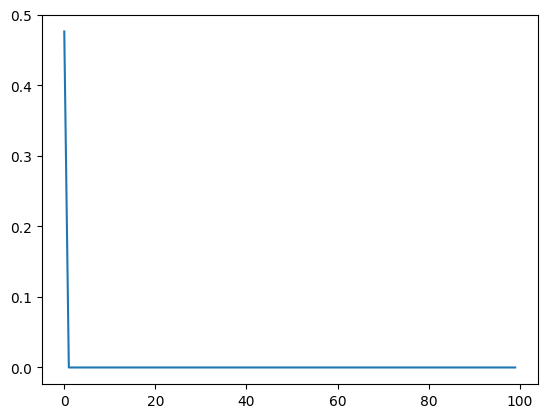

In [77]:
plt.plot(agent.av_ratio_record[0][0:99][90])
# plt.hlines(48,0,100,color='red',ls = '--')
# plt.hlines(25,0,100,color='blue',ls='-.')

In [114]:
agent.av_ratio_record[0]

array([[0.42857143, 0.32432432, 0.3022113 , ..., 0.34961   , 0.3477064 ,
        0.3411076 ],
       [0.5       , 0.5931677 , 0.4872554 , ..., 0.49320462, 0.49414991,
        0.49505581],
       [0.63636364, 0.63636364, 0.72077067, ..., 0.63832568, 0.63942315,
        0.64046462],
       ...,
       [0.28      , 0.28      , 0.29031989, ..., 0.52652794, 0.50365047,
        0.48156631],
       [0.52380952, 0.33294046, 0.30756249, ..., 0.55968609, 0.5416523 ,
        0.52090293],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [79]:
agent.av_num_record[0]

array([[10.,  0.,  0., ...,  0.,  0.,  0.],
       [ 7.,  0.,  0., ...,  0.,  0.,  0.],
       [10.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [13.,  0.,  0., ...,  0.,  0.,  0.],
       [12.,  0.,  0., ...,  0.,  0.,  0.],
       [11.,  0.,  0., ...,  0.,  0.,  0.]])

In [87]:
supply = []
demand = []
q = int(1600*1.5)
jam = int(240*1.5)
w = q/(jam-q/40)
for i in range(0,jam):
    k = i 
    supply.append(min(q,40*k))
    demand.append(min(q,w*(jam-k)))
# supply =max(0, min(self.q_max,1000*self.density * self.f_speed * self.dt / 3600)* self.length/1000)
#     self.demand =max(0, min(self.q_max,1000*(self.jam_density - self.density) * self.wave_speed * self.dt / 3600) * self.length/1000)


# self.q_max/(self.jam_density-self.q_max/self.f_speed)


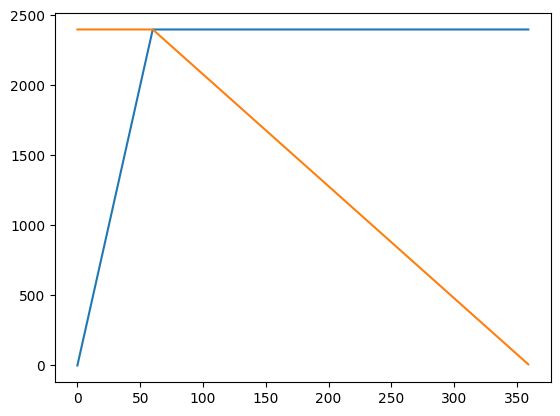

In [88]:
plt.plot(supply)

plt.plot(demand)

In [14]:
print(b)

NameError: name 'b' is not defined

In [15]:
ini_action

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

In [20]:
a = 1
b = a 
a = 3
print(b)

1


In [21]:
a = [1,2,3]
b = a 
a[1] = 10
print(b)

[1, 10, 3]
